In [1]:
# Import necessary libraries
import yfinance as yf
# Import necessary libraries
import pandas as pd
# Import necessary libraries
import numpy as np
# Import necessary libraries
import torch
# Import necessary libraries
import torch.nn as nn
# Import necessary libraries
import torch.optim as optim
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.utils.sampling import manual_seed
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.utils.transforms import unnormalize
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
# Split dataset into training and testing sets
from sklearn.model_selection import train_test_split
# Import necessary libraries
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
# Import necessary libraries
import requests
from datetime import timedelta

In [2]:
# =====================
# 1. Data Preparation
# =====================

# Define a function
def load_data(ticker, start_date, end_date):
    """Fetch data from Yahoo Finance."""
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Return'] = data['Close'].pct_change()
    data['SMA_10'] = data['Close'].rolling(10).mean()
    data['SMA_50'] = data['Close'].rolling(50).mean()
    data['RSI'] = compute_rsi(data['Close'])
    data['MACD'], data['Signal'] = compute_macd(data['Close'])
    data['Bollinger_Upper'], data['Bollinger_Lower'] = compute_bollinger_bands(data['Close'])
    data = data[['Close', 'Volume', 'Return', 'SMA_10', 'SMA_50', 'RSI', 'MACD', 'Signal', 'Bollinger_Upper', 'Bollinger_Lower']]
    data = data.dropna()  # Drop rows with NaN values
    return data

# Define a function
def compute_rsi(series, period=14):
    """Compute Relative Strength Index (RSI)."""
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Define a function
def compute_macd(series, short_window=12, long_window=26, signal_window=9):
    """Compute MACD and Signal Line."""
    short_ema = series.ewm(span=short_window, adjust=False).mean()
    long_ema = series.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

# Define a function
def compute_bollinger_bands(series, window=20, num_std_dev=2):
    """Compute Bollinger Bands."""
    rolling_mean = series.rolling(window).mean()
    rolling_std = series.rolling(window).std()
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    return upper_band, lower_band

# Define a function
def create_sequences(data, sequence_length):
    """Create sequences for time-series data."""
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length, 0])  # Target is the closing price
    return np.array(sequences), np.array(targets)

# Define a function
def preprocess_data(data, sequence_length):
    """Preprocess the data: scale and create sequences."""
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    sequences, targets = create_sequences(scaled_data, sequence_length)
    return sequences, targets, scaler



In [4]:
# Fetch data
ticker = "AAPL"  
start_date = "2000-01-01"
end_date = "2024-12-31"
data = load_data(ticker, start_date, end_date)

# Split data
train_data = data.loc[:"2022-12-31"]
validation_data = data.loc["2023-01-01":"2023-12-31"]

test_data = data.loc["2024-01-01":]

# Preprocess
data_sequence_length = 50
train_sequences, train_targets, train_scaler = preprocess_data(train_data.values, data_sequence_length)
val_sequences, val_targets, _ = preprocess_data(validation_data.values, data_sequence_length)

test_sequences, test_targets, __ = preprocess_data(test_data.values, data_sequence_length)

# Convert to PyTorch tensors
X_train = torch.tensor(train_sequences, dtype=torch.float32)
y_train = torch.tensor(train_targets, dtype=torch.float32)
X_val = torch.tensor(val_sequences, dtype=torch.float32)
y_val = torch.tensor(val_targets, dtype=torch.float32)

X_test = torch.tensor(test_sequences, dtype=torch.float32)
y_test = torch.tensor(test_targets, dtype=torch.float32)

[*********************100%***********************]  1 of 1 completed


In [11]:
class HybridModelLSTMGRUTCNN(nn.Module):
# Define a function
    def __init__(self, num_filters, kernel_size, lstm_units, gru_units, dropout_rate):
        super(HybridModelLSTMGRUTCNN, self).__init__()
        
        # TCNN Layer
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=50, out_channels=num_filters, kernel_size=kernel_size),  # 10 features as in_channels
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)  # Reduce sequence length
        )
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size=num_filters, hidden_size=lstm_units, batch_first=True)
        
        # GRU Layer
        self.gru = nn.GRU(input_size=num_filters, hidden_size=gru_units, batch_first=True)
        
        # Dropout Layer
        self.dropout = nn.Dropout(dropout_rate)
        
        # Batch Normalization Layer
        self.batch_norm = nn.BatchNorm1d(lstm_units + gru_units)
        
        # Fully Connected Layer
        self.fc = nn.Linear(lstm_units + gru_units, 1)

# Define a function
    def forward(self, x):
        # Permute input for Conv1d: [batch, seq_length, features] -> [batch, features, seq_length]
        x = x.permute(0, 2, 1)
        
        # TCNN Processing
        x = self.cnn(x)
        
        # Permute back for LSTM/GRU compatibility: [batch, features, seq_length] -> [batch, seq_length, features]
        x = x.permute(0, 2, 1)
        
        # LSTM Processing
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Take the last output of LSTM
        
        # GRU Processing
        gru_out, _ = self.gru(x)
        gru_out = gru_out[:, -1, :]  # Take the last output of GRU
        
        # Concatenate LSTM and GRU outputs
        combined = torch.cat((lstm_out, gru_out), dim=1)
        
        # Apply Batch Normalization
        combined = self.batch_norm(combined)
        
        # Dropout and Fully Connected Layer
        combined = self.dropout(combined)
        output = self.fc(combined)
        
        return output


In [35]:
# =============================
# 3.1 Optimise Hyperparameters
# =============================

# Objective function for hyperparameter optimization
# Define a function
def train_and_evaluate(params):
    """Train the model with given hyperparameters and return the validation loss."""
    # Ensure params can be unpacked properly
    if isinstance(params, torch.Tensor):
        params = params.squeeze().tolist()  # Convert tensor to a list

    num_filters, kernel_size, lstm_units, gru_units, dropout_rate, learning_rate, weight_decay, patience, factor = params

    model = HybridModelLSTMGRUTCNN(
        num_filters=int(num_filters),
        kernel_size=int(kernel_size),
        lstm_units=int(lstm_units),
        gru_units=int(gru_units),
        dropout_rate=dropout_rate
    )
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=int(patience), factor=factor)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
    
    # Train for a few epochs to evaluate
    num_epochs = 5  # Short training to evaluate hyperparameters
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.permute(0, 2, 1)
            batch_y = batch_y.unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_X_perm = X_val.permute(0, 2, 1)
            val_y_pred = model(val_X_perm)
            val_loss = criterion(val_y_pred, y_val.unsqueeze(1)).item()

        scheduler.step(val_loss)

    return torch.tensor(val_loss)



# Define the search space
bounds = torch.tensor([
    [32, 1, 64, 64, 0.1, 0.00001, 1e-6, 1, 0.1],   # Lower bounds
    [128, 5, 256, 256, 0.5, 0.01, 1e-3, 10, 0.9]   # Upper bounds
])  # [num_filters, kernel_size, lstm_units, gru_units, dropout_rate, learning_rate, weight_decay, patience, factor]

# Generate initial data
X_init = torch.rand(10, bounds.size(1))  # 10 random initial points
Y_init = torch.tensor([train_and_evaluate(unnormalize(x, bounds)).item() for x in X_init]).unsqueeze(-1)

# Fit a GP model
gp = SingleTaskGP(X_init, Y_init)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_model(mll)

# Optimize the acquisition function
acq_func = UpperConfidenceBound(gp, beta=0.1)



c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0555]), std = tensor([0.0387])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [29]:
# Define a function
def optimize_hyperparameters(iterations=10):
    """Perform Bayesian Optimization for the given number of iterations."""
    global X_init, Y_init, gp, mll, acq_func

    # Ensure initialization consistency
    n_samples = min(X_init.shape[0], Y_init.shape[0])
    X_init = X_init[:n_samples, :]
    Y_init = Y_init[:n_samples, :]

    if X_init.shape[0] != Y_init.shape[0]:
        raise ValueError(f"Initialization mismatch after adjustment: X_init has {X_init.shape[0]} samples, but Y_init has {Y_init.shape[0]} samples.")

    for i in range(iterations):
        print(f"X_init shape: {X_init.shape}")
        print(f"Y_init shape: {Y_init.shape}")

        # Optimize the acquisition function
        new_x, _ = optimize_acqf(
            acq_function=acq_func,
            bounds=torch.stack([torch.zeros(bounds.size(1)), torch.ones(bounds.size(1))]),
            q=1,
            num_restarts=10,
            raw_samples=100,
        )

        # Unnormalize parameters
        unnormalized_params = unnormalize(new_x, bounds)
        print(f"Unnormalized params: {unnormalized_params}")  # Debugging output

        # Evaluate the objective function
        new_y = train_and_evaluate(unnormalized_params).unsqueeze(0).unsqueeze(-1)  # Ensure shape [1, 1]
        print(f"new_y: {new_y}")  # Debugging output

        print(f"new_x shape: {new_x.shape}")
        print(f"new_y shape: {new_y.shape}")

        # Verify consistency in shapes
        if new_x.shape[1] != X_init.shape[1]:
            raise ValueError(f"Feature size mismatch: new_x.shape[1] ({new_x.shape[1]}) != X_init.shape[1] ({X_init.shape[1]})")
        if new_y.shape[1] != Y_init.shape[1]:
            raise ValueError(f"Target size mismatch: new_y.shape[1] ({new_y.shape[1]}) != Y_init.shape[1] ({Y_init.shape[1]})")

        # Update the data
        X_init = torch.cat([X_init, new_x], dim=0)  # Shape: [n_samples + 1, feature_dim]
        Y_init = torch.cat([Y_init, new_y], dim=0)  # Shape: [n_samples + 1, 1]

        # Ensure consistency after concatenation
        if X_init.shape[0] != Y_init.shape[0]:
            raise ValueError(f"Shape mismatch after update: X_init has {X_init.shape[0]} samples, but Y_init has {Y_init.shape[0]} samples.")

        # Update the GP model
        gp = SingleTaskGP(X_init, Y_init)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_model(mll)

        print(f"Iteration {i+1}/{iterations}: Best Loss = {Y_init.min().item():.4f}")


In [30]:
# Run the optimization
optimize_hyperparameters(iterations=20)


X_init shape: torch.Size([14, 9])
Y_init shape: torch.Size([14, 1])
Unnormalized params: tensor([[4.9587e+01, 3.7993e+00, 2.3174e+02, 2.4479e+02, 1.5269e-01, 1.7044e-03,
         2.5376e-04, 4.7264e+00, 4.5800e-01]])
new_y: tensor([[0.0432]])
new_x shape: torch.Size([1, 9])
new_y shape: torch.Size([1, 1])


c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0903]), std = tensor([0.1299])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 1/20: Best Loss = 0.0136
X_init shape: torch.Size([15, 9])
Y_init shape: torch.Size([15, 1])
Unnormalized params: tensor([[6.8694e+01, 3.4885e+00, 1.5568e+02, 1.3340e+02, 1.7761e-01, 2.2718e-03,
         8.4863e-04, 7.5746e+00, 4.8267e-01]])
new_y: tensor([[0.0387]])
new_x shape: torch.Size([1, 9])
new_y shape: torch.Size([1, 1])


c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0871]), std = tensor([0.1262])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 2/20: Best Loss = 0.0136
X_init shape: torch.Size([16, 9])
Y_init shape: torch.Size([16, 1])
Unnormalized params: tensor([[5.0113e+01, 3.7936e+00, 9.5742e+01, 2.1373e+02, 1.0771e-01, 9.2030e-03,
         6.5716e-05, 5.8889e+00, 6.7543e-01]])
new_y: tensor([[0.6334]])
new_x shape: torch.Size([1, 9])
new_y shape: torch.Size([1, 1])


c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1192]), std = tensor([0.1802])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 3/20: Best Loss = 0.0136
X_init shape: torch.Size([17, 9])
Y_init shape: torch.Size([17, 1])
Unnormalized params: tensor([[4.2528e+01, 1.2269e+00, 2.1310e+02, 1.3958e+02, 4.5345e-01, 6.3366e-03,
         1.2425e-04, 2.1792e+00, 2.6372e-01]])
new_y: tensor([[0.0451]])
new_x shape: torch.Size([1, 9])
new_y shape: torch.Size([1, 1])


c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1151]), std = tensor([0.1757])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 4/20: Best Loss = 0.0136
X_init shape: torch.Size([18, 9])
Y_init shape: torch.Size([18, 1])
Unnormalized params: tensor([[7.9463e+01, 3.5398e+00, 7.0808e+01, 2.1725e+02, 1.4443e-01, 8.4529e-03,
         4.0548e-04, 8.1194e+00, 7.8693e-01]])
new_y: tensor([[0.1326]])
new_x shape: torch.Size([1, 9])
new_y shape: torch.Size([1, 1])


c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1160]), std = tensor([0.1708])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 5/20: Best Loss = 0.0136
X_init shape: torch.Size([19, 9])
Y_init shape: torch.Size([19, 1])
Unnormalized params: tensor([[6.3390e+01, 4.3971e+00, 1.3740e+02, 2.0586e+02, 1.2842e-01, 8.6469e-03,
         2.8526e-04, 8.2424e+00, 5.9279e-01]])
new_y: tensor([[0.2228]])
new_x shape: torch.Size([1, 9])
new_y shape: torch.Size([1, 1])


c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1214]), std = tensor([0.1680])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 6/20: Best Loss = 0.0136
X_init shape: torch.Size([20, 9])
Y_init shape: torch.Size([20, 1])
Unnormalized params: tensor([[5.5772e+01, 2.4101e+00, 2.3673e+02, 6.6372e+01, 1.3259e-01, 8.0338e-03,
         1.3703e-04, 8.7925e+00, 8.1112e-01]])
new_y: tensor([[0.8543]])
new_x shape: torch.Size([1, 9])
new_y shape: torch.Size([1, 1])


c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1563]), std = tensor([0.2289])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 7/20: Best Loss = 0.0136
X_init shape: torch.Size([21, 9])
Y_init shape: torch.Size([21, 1])
Unnormalized params: tensor([[3.9635e+01, 2.9133e+00, 2.0654e+02, 1.0209e+02, 1.8728e-01, 6.2726e-04,
         3.7265e-05, 8.0511e+00, 8.9834e-01]])
new_y: tensor([[0.0169]])
new_x shape: torch.Size([1, 9])
new_y shape: torch.Size([1, 1])


c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1499]), std = tensor([0.2253])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 8/20: Best Loss = 0.0136
X_init shape: torch.Size([22, 9])
Y_init shape: torch.Size([22, 1])
Unnormalized params: tensor([[5.1177e+01, 4.3588e+00, 2.4764e+02, 1.6902e+02, 2.5185e-01, 5.4662e-03,
         6.0044e-04, 1.5056e+00, 1.8504e-01]])
new_y: tensor([[0.0315]])
new_x shape: torch.Size([1, 9])
new_y shape: torch.Size([1, 1])


c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1448]), std = tensor([0.2215])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 9/20: Best Loss = 0.0136
X_init shape: torch.Size([23, 9])
Y_init shape: torch.Size([23, 1])
Unnormalized params: tensor([[4.5966e+01, 1.1892e+00, 2.3230e+02, 1.3292e+02, 4.8617e-01, 6.1009e-03,
         7.0553e-04, 3.6392e+00, 4.2285e-01]])
new_y: tensor([[0.0716]])
new_x shape: torch.Size([1, 9])
new_y shape: torch.Size([1, 1])


c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1417]), std = tensor([0.2172])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 10/20: Best Loss = 0.0136
X_init shape: torch.Size([24, 9])
Y_init shape: torch.Size([24, 1])
Unnormalized params: tensor([[9.0783e+01, 3.4942e+00, 2.1120e+02, 8.6720e+01, 1.1926e-01, 8.5019e-03,
         1.2580e-04, 8.5188e+00, 3.5680e-01]])
new_y: tensor([[0.7210]])
new_x shape: torch.Size([1, 9])
new_y shape: torch.Size([1, 1])


c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1649]), std = tensor([0.2421])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 11/20: Best Loss = 0.0136
X_init shape: torch.Size([25, 9])
Y_init shape: torch.Size([25, 1])
Unnormalized params: tensor([[1.1485e+02, 4.7785e+00, 1.9099e+02, 1.7294e+02, 2.7162e-01, 5.1573e-03,
         8.1234e-04, 5.5190e+00, 1.3224e-01]])
new_y: tensor([[0.0371]])
new_x shape: torch.Size([1, 9])
new_y shape: torch.Size([1, 1])


c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1600]), std = tensor([0.2385])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


Iteration 12/20: Best Loss = 0.0136
X_init shape: torch.Size([26, 9])
Y_init shape: torch.Size([26, 1])
Unnormalized params: tensor([[7.8868e+01, 3.3881e+00, 1.3948e+02, 1.3253e+02, 1.2555e-01, 4.6298e-03,
         8.9663e-06, 7.2046e+00, 7.2767e-01]])
new_y: tensor([[0.3440]])
new_x shape: torch.Size([1, 9])
new_y shape: torch.Size([1, 1])


c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1668]), std = tensor([0.2366])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 13/20: Best Loss = 0.0136
X_init shape: torch.Size([27, 9])
Y_init shape: torch.Size([27, 1])
Unnormalized params: tensor([[8.0955e+01, 4.8637e+00, 7.6224e+01, 1.1888e+02, 1.9420e-01, 1.7652e-03,
         3.9672e-04, 9.4546e+00, 5.2640e-01]])
new_y: tensor([[0.0746]])
new_x shape: torch.Size([1, 9])
new_y shape: torch.Size([1, 1])


c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1635]), std = tensor([0.2328])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 14/20: Best Loss = 0.0136
X_init shape: torch.Size([28, 9])
Y_init shape: torch.Size([28, 1])
Unnormalized params: tensor([[1.1491e+02, 4.5002e+00, 6.8360e+01, 1.4382e+02, 1.1605e-01, 9.5538e-03,
         1.9602e-04, 2.3549e+00, 8.5598e-01]])
new_y: tensor([[1.1047]])
new_x shape: torch.Size([1, 9])
new_y shape: torch.Size([1, 1])


c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1960]), std = tensor([0.2878])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 15/20: Best Loss = 0.0136
X_init shape: torch.Size([29, 9])
Y_init shape: torch.Size([29, 1])
Unnormalized params: tensor([[6.0362e+01, 4.3724e+00, 1.9380e+02, 1.2023e+02, 1.1240e-01, 4.8566e-05,
         9.3249e-04, 2.6555e+00, 1.7372e-01]])
new_y: tensor([[0.0149]])
new_x shape: torch.Size([1, 9])
new_y shape: torch.Size([1, 1])


c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1899]), std = tensor([0.2847])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


Iteration 16/20: Best Loss = 0.0136
X_init shape: torch.Size([30, 9])
Y_init shape: torch.Size([30, 1])
Unnormalized params: tensor([[7.9433e+01, 4.1092e+00, 2.4764e+02, 2.4043e+02, 2.3110e-01, 9.9117e-03,
         7.8823e-04, 4.1128e+00, 7.2018e-01]])
new_y: tensor([[1.0728]])
new_x shape: torch.Size([1, 9])
new_y shape: torch.Size([1, 1])


c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2184]), std = tensor([0.3217])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 17/20: Best Loss = 0.0136
X_init shape: torch.Size([31, 9])
Y_init shape: torch.Size([31, 1])
Unnormalized params: tensor([[4.0459e+01, 2.5210e+00, 1.7406e+02, 8.6203e+01, 1.3387e-01, 6.7865e-03,
         1.5364e-04, 7.2969e+00, 7.1319e-01]])
new_y: tensor([[0.0366]])
new_x shape: torch.Size([1, 9])
new_y shape: torch.Size([1, 1])


c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2127]), std = tensor([0.3181])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 18/20: Best Loss = 0.0136
X_init shape: torch.Size([32, 9])
Y_init shape: torch.Size([32, 1])
Unnormalized params: tensor([[5.2466e+01, 4.2495e+00, 9.0052e+01, 2.2600e+02, 2.0133e-01, 8.0163e-03,
         7.8239e-04, 7.9368e+00, 6.1804e-01]])
new_y: tensor([[0.0511]])
new_x shape: torch.Size([1, 9])
new_y shape: torch.Size([1, 1])


c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2078]), std = tensor([0.3143])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 19/20: Best Loss = 0.0136
X_init shape: torch.Size([33, 9])
Y_init shape: torch.Size([33, 1])
Unnormalized params: tensor([[8.0912e+01, 4.4534e+00, 1.3533e+02, 1.9360e+02, 1.4396e-01, 8.7382e-03,
         8.2971e-04, 8.1825e+00, 8.9932e-01]])
new_y: tensor([[0.1350]])
new_x shape: torch.Size([1, 9])
new_y shape: torch.Size([1, 1])


c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\domen\anaconda3\envs\thesis\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2057]), std = tensor([0.3098])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 20/20: Best Loss = 0.0136


In [36]:

# Best hyperparameters
best_x = X_init[torch.argmin(Y_init)]
best_hyperparams = unnormalize(best_x, bounds)
print("Best Hyperparameters:", best_hyperparams)

best_hyperparams_list = best_hyperparams.tolist()

# Unpack values into individual variables
num_filters, kernel_size, lstm_units, gru_units, dropout_rate, learning_rate, weight_decay, patience, factor = best_hyperparams_list

# Print each variable
print(f"num_filters: {num_filters}")
print(f"kernel_size: {kernel_size}")
print(f"lstm_units: {lstm_units}")
print(f"gru_units: {gru_units}")
print(f"dropout_rate: {dropout_rate}")
print(f"learning_rate: {learning_rate}")
print(f"weight_decay: {weight_decay}")
print(f"patience: {patience}")
print(f"factor: {factor}")

Best Hyperparameters: tensor([5.2081e+01, 4.9613e+00, 1.5446e+02, 1.5012e+02, 1.0732e-01, 5.6880e-03,
        9.4823e-04, 2.8883e+00, 5.7396e-01])
num_filters: 52.081077575683594
kernel_size: 4.961319923400879
lstm_units: 154.4553680419922
gru_units: 150.1215057373047
dropout_rate: 0.10731575638055801
learning_rate: 0.005687965080142021
weight_decay: 0.0009482332388870418
patience: 2.8882510662078857
factor: 0.5739561319351196


In [50]:
# =========================
# 4. Train the Model
# =========================

num_filters = 48
kernel_size = 3
lstm_units = 96
gru_units = 164
dropout_rate = 0.2
learning_rate = 0.0005
weight_decay_ = 0.0005
patience_ = 2
factor_ = 0.12402038276195526

batch_size = 32

num_epochs = 50

# Initialize the model
model = HybridModelLSTMGRUTCNN(num_filters, kernel_size, lstm_units, gru_units, dropout_rate)

# Loss, optimizer, and scheduler
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=patience_, factor=factor_)

# DataLoader
train_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(X_train, y_train),
    batch_size=batch_size,
    shuffle=True,
)

train_losses = []
val_losses = []



In [51]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.permute(0, 2, 1)
        batch_y = batch_y.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        X_val_perm = X_val.permute(0, 2, 1)
        y_val_pred = model(X_val_perm)
        y_val_target = y_val.unsqueeze(1)
        val_loss = criterion(y_val_pred, y_val_target).item()
        val_losses.append(val_loss)

    scheduler.step(epoch_loss / len(train_loader))
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")
    



Epoch 1/50, Train Loss: 0.0781, Validation Loss: 0.1606
Epoch 2/50, Train Loss: 0.0430, Validation Loss: 0.0467
Epoch 3/50, Train Loss: 0.0312, Validation Loss: 0.0128
Epoch 4/50, Train Loss: 0.0210, Validation Loss: 0.0120
Epoch 5/50, Train Loss: 0.0141, Validation Loss: 0.0113
Epoch 6/50, Train Loss: 0.0072, Validation Loss: 0.0136
Epoch 7/50, Train Loss: 0.0049, Validation Loss: 0.0058
Epoch 8/50, Train Loss: 0.0042, Validation Loss: 0.0086
Epoch 9/50, Train Loss: 0.0034, Validation Loss: 0.0265
Epoch 10/50, Train Loss: 0.0032, Validation Loss: 0.0062
Epoch 11/50, Train Loss: 0.0030, Validation Loss: 0.0051
Epoch 12/50, Train Loss: 0.0028, Validation Loss: 0.0083
Epoch 13/50, Train Loss: 0.0030, Validation Loss: 0.0065
Epoch 14/50, Train Loss: 0.0023, Validation Loss: 0.0047
Epoch 15/50, Train Loss: 0.0025, Validation Loss: 0.0071
Epoch 16/50, Train Loss: 0.0023, Validation Loss: 0.0104
Epoch 17/50, Train Loss: 0.0024, Validation Loss: 0.0119
Epoch 18/50, Train Loss: 0.0023, Validat

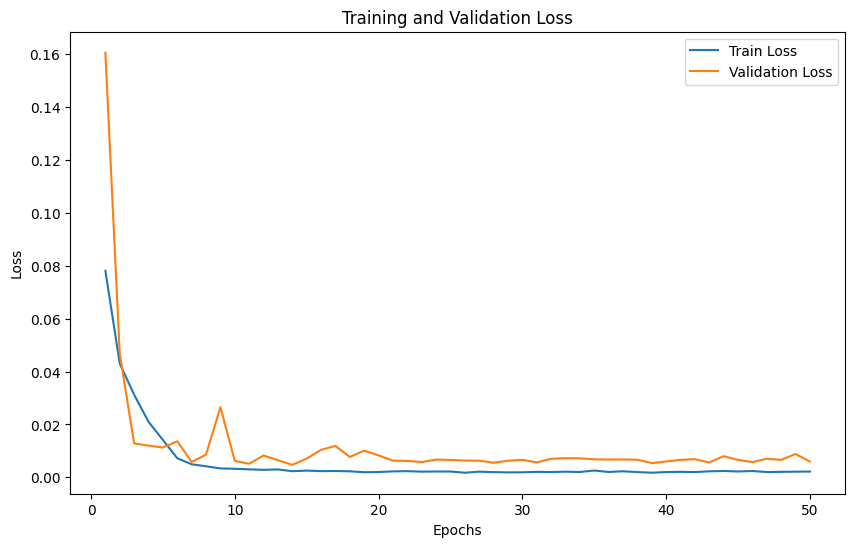

In [52]:
# Plot Loss
plt.figure(figsize=(10, 6))
# Plot the results
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
# Plot the results
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [53]:
# Save the entire model
torch.save(model, "hybrid_model2.pth")
print("Entire model saved successfully!")


Entire model saved successfully!


In [54]:
loss_df = pd.DataFrame({
    "Epoch": list(range(1, len(train_losses) + 1)),
    "Train Loss": train_losses,
    "Validation Loss": val_losses
})

# Save to CSV
loss_df.to_csv("loss_data2.csv", index=False)
print("Loss data saved as CSV successfully!")

Loss data saved as CSV successfully!


In [ ]:
# Load the entire model
model = torch.load("hybrid_model.pth")
model.eval()
print("Entire model loaded successfully!")

In [ ]:
# Load loss data from CSV
# Load dataset using pandas
loss_df = pd.read_csv("loss_data.csv")

train_losses = loss_df["Train Loss"].tolist()
val_losses = loss_df["Validation Loss"].tolist()

print("Loss data loaded from CSV successfully!")


In [55]:
model.eval()
with torch.no_grad():
    X_test_perm = X_test.permute(0, 2, 1)
    y_test_pred = model(X_test_perm)
    y_test_target = y_test.unsqueeze(1)

In [56]:
actual_values = y_test_target.cpu().numpy()
predictions = y_test_pred.cpu().numpy()

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(actual_values, predictions)
mse = mean_squared_error(actual_values, predictions)
r2 = r2_score(actual_values, predictions)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 0.0731
Mean Squared Error (MSE): 0.0088
R² Score: 0.8754


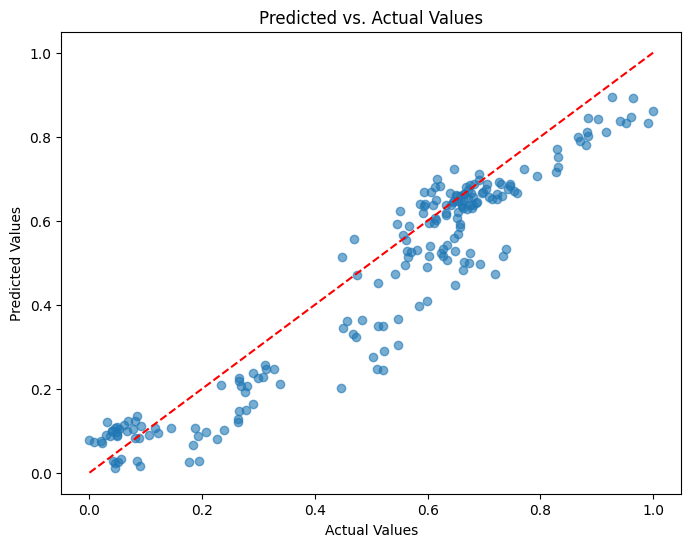

In [58]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Scatter plot for predictions vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predictions, alpha=0.6)
# Plot the results
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.show()


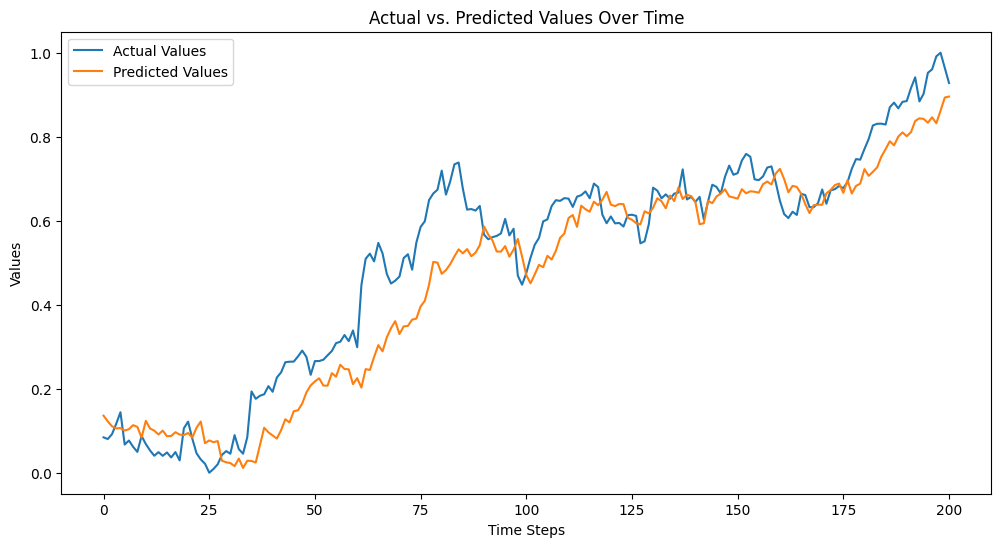

In [59]:
plt.figure(figsize=(12, 6))
# Plot the results
plt.plot(actual_values, label='Actual Values')
# Plot the results
plt.plot(predictions, label='Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.show()
